In [25]:
import findspark
findspark.init("/h/224/cameron/spark-3.0.0-preview2-bin-hadoop2.7")
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tempfile
import tqdm

In [2]:
spark = SparkSession.builder.getOrCreate()
spark.sparkContext.getConf().getAll()

[('spark.driver.host', 'adavm1.ais.sandbox'),
 ('spark.app.id', 'local-1590801362993'),
 ('spark.driver.memory', '400g'),
 ('spark.driver.port', '36351'),
 ('spark.executor.id', 'driver'),
 ('spark.app.name', 'PySparkShell'),
 ('spark.executor.memory', '400g'),
 ('spark.sql.catalogImplementation', 'hive'),
 ('spark.rdd.compress', 'True'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.executor.cores', '16'),
 ('spark.master', 'local[*]'),
 ('spark.submit.pyFiles', ''),
 ('spark.submit.deployMode', 'client'),
 ('spark.ui.showConsoleProgress', 'true')]

In [3]:
# Load the Parquet data
df = spark.read.load("/comments_2019.parquet").fillna("")
df.createOrReplaceTempView("comments")
political_comments = spark.sql("""select subreddit, author, created_utc from comments 
                                  where subreddit in 
                                      ("JoeBiden","Pete_Buttigieg","Kamala",
                                      "SandersForPresident","BetoORourke","ElizabethWarren",
                                      "BaemyKlobaechar","YangForPresidentHQ","politics","progressive",
                                      "demsocialist","SocialDemocracy","centerleftpolitics","ConservativeDemocrat",
                                      "moderatepolitics")
                                """)
political_comments.printSchema()
political_comments.count()

root
 |-- subreddit: string (nullable = false)
 |-- author: string (nullable = false)
 |-- created_utc: integer (nullable = true)



27987473

## Word2Vecf Files
[Word2vecf](https://github.com/BIU-NLP/word2vecf/blob/master/README.md) requires three inputs
* word_vocabulary: file mapping subreddits (strings) to their counts
* count_vocabulary: file mapping users (contexts -> subreddit commenters) to their counts
* training_data: text file of word-context pairs (space delimited)


### Word Vocabulary

In [4]:
word_vocabulary = political_comments.groupBy("subreddit").count()
word_vocabulary.show()

+--------------------+--------+
|           subreddit|   count|
+--------------------+--------+
|     BaemyKlobaechar|    1156|
|    moderatepolitics|  219198|
|  centerleftpolitics|  550117|
| SandersForPresident|  794501|
|  YangForPresidentHQ| 1186934|
|              Kamala|   10590|
|     SocialDemocracy|    6977|
|            politics|24736772|
|         BetoORourke|     795|
|        demsocialist|    1135|
|      Pete_Buttigieg|  354883|
|ConservativeDemocrat|     650|
|         progressive|   16565|
|            JoeBiden|   15303|
|     ElizabethWarren|   91897|
+--------------------+--------+



### Context Vocabulary

In [5]:
context_vocabulary = political_comments.groupBy("author").count()
context_vocabulary.show()

+-------------------+-----+
|             author|count|
+-------------------+-----+
|          FoxRaptix| 4817|
|            x-eNzym|   61|
|       petersracing|   29|
|  GorillaGlueWookie|  283|
|             jplvhp|  269|
|       puffthisfish|   42|
|         censorinus|  562|
|            JyveAFK|  262|
|Pooptypeuptypants55|    8|
|      Itssteakliara| 1165|
|         DoopSlayer| 2582|
|     Peepsandspoops| 1658|
|     ReadySteady_GO|  237|
|        1maxwellian|   60|
|  TreasonousTeacher|   68|
|       advancedlamb|  127|
|           zerobass| 2919|
|    bestbeforeMar91|  638|
|   anonymous_potato| 1147|
|INSIDIOUS_ROOT_BEER|   16|
+-------------------+-----+
only showing top 20 rows



### Training Data

In [6]:
training_data = political_comments.groupBy("subreddit","author").count()
training_data.show()

+-------------------+-------------------+-----+
|          subreddit|             author|count|
+-------------------+-------------------+-----+
| centerleftpolitics|     ILikeBigButtss| 6571|
|           politics|        DBCOOPER888|  784|
|           politics|    GameOvaries1107|  480|
|           politics|          tsuwraith|   12|
|           politics|          NerdAtSea| 2766|
|           politics|        NoYamShazam|  662|
|           politics|            Pronell|   53|
|           politics|       Trustbutnone|  577|
|           politics|         sexydadbod|  123|
|           politics|     thirstytrumpet|   39|
|           politics|engineeringsquirrel|   72|
|           politics|           oggi-llc|  351|
|           politics|            IAmFern|  581|
|           politics|        LordBitness|   35|
|           politics|        badlands_94|  150|
|           politics|     Lush_Rimbaugh1|   23|
|           politics|          shotgun72|  253|
|           politics|           adam2222

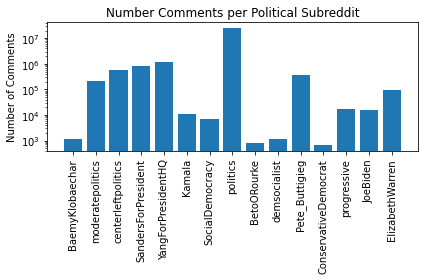

In [7]:
wdf = word_vocabulary.toPandas()
fig = plt.figure()
plt.yscale('log')
plt.title('Number Comments per Political Subreddit')

# plt.xlabel('Duration (in seconds)')
plt.ylabel('Number of Comments')
plt.bar(wdf["subreddit"],wdf["count"])
plt.xticks(rotation='vertical')
fig.tight_layout()

## Hyperparameter Sweep

In [8]:
# Create a temp context for the word and context vocabulary files (which get passed to the word2vecf script)
temp_dir = tempfile.TemporaryDirectory()

In [9]:
# Create temp files
file_data = os.path.join(temp_dir.name, 'data.txt')
file_wv = os.path.join(temp_dir.name, 'wv.txt')
file_cv = os.path.join(temp_dir.name, 'cv.txt')

In [10]:
print("Writing training data to {}...".format(file_data))
training_data.select("subreddit", "author").toPandas().to_csv(file_data, header=False, index=False, sep=' ')
print("Writing word vocab data to {}...".format(file_wv))
word_vocabulary.toPandas().to_csv(file_wv, header=False, index=False, sep=' ')
print("Writing context vocab data to {}...".format(file_cv))
context_vocabulary.toPandas().to_csv(file_cv, header=False, index=False, sep=' ')

Writing training data to /tmp/tmp35a_f26t/data.txt...
Writing word vocab data to /tmp/tmp35a_f26t/wv.txt...
Writing context vocab data to /tmp/tmp35a_f26t/cv.txt...


In [23]:
# Word2vec parameters, using negative sampling
param1_values = np.linspace(0.001, 0.01, 11)
param2_values = np.linspace(5, 95, 11)
def add_args(p1,p2): 
    embedding_args = {"param1": "sample", 
                  "p1": None, 
                  "param2": "negative", 
                  "p2": None, 
                  "file_data": file_data , 
                  "file_wv": file_wv, 
                  "file_cv": file_cv
                 }
    embedding_args["p1"] = p1 
    embedding_args["p2"] = p2
    return embedding_args
all_embeddings = [ add_args(p1, p2) for p1 in param1_values for p2 in param2_values]

In [31]:
import subprocess
import sys
import os

def generate_embedding(p1, p2, param1, param2, file_data, file_wv, file_cv):
    output = "vecs_{}_{}.txt".format(p1,p2)
    command = "./word2vecf/word2vecf -train {} -wvocab {} -cvocab {} -output {} -threads 180 -alpha 0.26 -size 200 -{} {} -{} {}".format(file_data,file_wv,file_cv,output,param1,p1,param2,p2)
    if not os.path.exists(output):
        subprocess.run(command, shell=True)
    
    return output

In [32]:
generated_embeddings = [generate_embedding(**args) for args in all_embeddings]

In [14]:
def load_embedding(filename):
    embedding = pd.read_csv(filename, sep=' ', header=None, skiprows=1)
    embedding.set_index(0)
    embedding = embedding.rename(columns={0: 'subreddits'})
    subreddits, vectors = embedding.iloc[:, 0], embedding.iloc[:, 1:200]
    vectors = vectors.divide(np.linalg.norm(vectors, axis=1), axis=0)
    return subreddits, vectors

In [37]:
loaded_embedding = load_embedding("vecs_0.0019000000000000002_68.0.txt")
# loaded_embeddings = list(map(lambda x: load_embedding(x), tqdm(generated_embeddings)))
loaded_embedding

(0          BaemyKlobaechar
 1                 politics
 2       YangForPresidentHQ
 3      SandersForPresident
 4       centerleftpolitics
 5           Pete_Buttigieg
 6         moderatepolitics
 7          ElizabethWarren
 8              progressive
 9                 JoeBiden
 10                  Kamala
 11         SocialDemocracy
 12            demsocialist
 13             BetoORourke
 14    ConservativeDemocrat
 Name: subreddits, dtype: object,
          1         2         3         4         5         6         7    \
 0   0.026471 -0.021911  0.046089  0.015855  0.130270 -0.006559  0.061060   
 1   0.036563 -0.030239  0.043722 -0.002132  0.163529 -0.019090  0.058710   
 2   0.044567 -0.035596  0.033617 -0.014359  0.146600 -0.017552  0.081880   
 3   0.045379 -0.038153  0.061412 -0.003472  0.220167 -0.025781  0.111084   
 4  -0.028204  0.010925  0.011220  0.026377 -0.038480  0.008604  0.002269   
 5   0.040081 -0.030411  0.056951  0.011408  0.181572 -0.017046  0.081397   
 6   0.

### Reduce to 3 dimensions

In [35]:
from sklearn.decomposition import PCA
# PCA Dim Reduction
pca =  PCA(n_components = 3)
three_dim =  pd.DataFrame(pca.fit_transform(vectors))
three_dim['subreddit'] = subreddits

In [36]:
import plotly.express as px
fig = px.scatter_3d(three_dim, x=0, y=1, z=2,text="subreddit")
fig.show()

### Reduce to 2 dimensions

In [38]:
# PCA Dim Reduction
pca =  PCA(n_components = 2)
two_dim =  pd.DataFrame(pca.fit_transform(vectors))
two_dim['subreddit'] = subreddits
fig = px.scatter(two_dim, x=0, y=1,text="subreddit")
fig.show()